### Histograms in machine vision
- Represent the distribution of colours in an image.
- Can serve as feature vectors -> are images with similar histograms semantically similar?
- Measuring distance between histograms:
    - Euclidean
    - Correlation
    - Chi-squared
    - Intersection
    - Battacharyya

In [1]:
# cv2.calcHist(images, channels, mask, histSize, ranges)
# images -> list of images to compute hists for
# list of channels we want to compute a histogram for
# mask -> Filter of our choice
# histSize -> Number of bins to use in histogram (one for each channel)
# ranges -> ranges of possible px values (e.g. [0, 256])

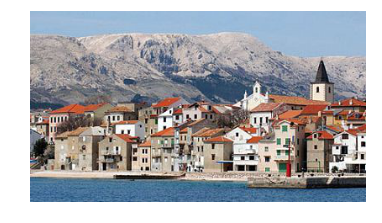

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
%matplotlib inline
plt.style.use('bmh')

image = cv2.imread('./images/baske.jpg')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off');

In [3]:
hist = cv2.calcHist([image], [0], mask=None, histSize=[256],
                    ranges=[0, 256])

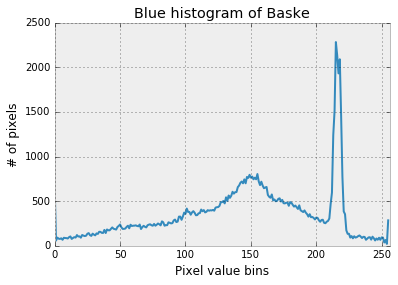

In [4]:
plt.plot(hist)
plt.xlim([0, 256])
plt.xlabel('Pixel value bins')
plt.ylabel('# of pixels')
plt.title('Blue histogram of Baske');

In [5]:
hist_g = cv2.calcHist([cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)],
                      [0], None, [256], [0, 256])

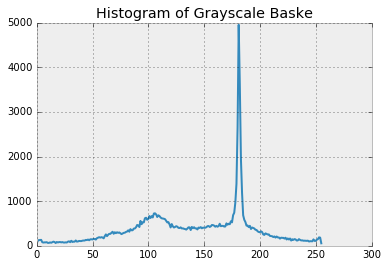

In [6]:
plt.plot(hist_g)
plt.title('Histogram of Grayscale Baske');

And for each of the channels in isolation?

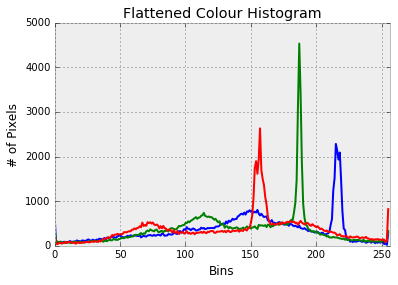

In [8]:
chans = cv2.split(image) # Splits image into 3 channels
c = ['b', 'g', 'r']
features = []

for color, chan in zip(c, chans):
    # Compute the histogram
    h = cv2.calcHist([chan], [0], None, [256], [0, 256])
    # Append the histogram to flattened histogram
    features.extend(hist)
    # Plot the histogram
    plt.plot(h, color=color)
    plt.xlim([0, 256])
plt.title('Flattened Colour Histogram')
plt.xlabel('Bins')
plt.ylabel('# of Pixels');

Next up - multidimensional histograms. These are joint distributions for different channels' values.

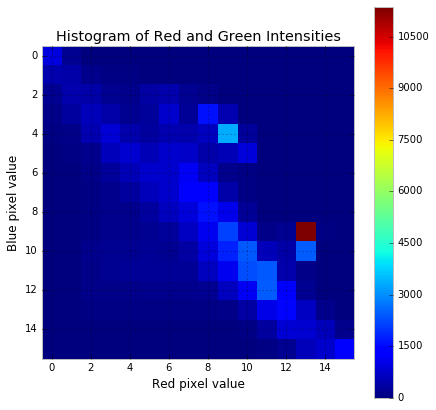

In [9]:
plt.figure(figsize=(7, 7))
hist = cv2.calcHist([chans[2], chans[0]], [0, 1], None, [16, 16],
                    [0, 256, 0, 256])
p = plt.imshow(hist, interpolation='nearest')
plt.colorbar(p)
plt.title('Histogram of Red and Green Intensities')
plt.xlabel('Red pixel value');
plt.ylabel('Blue pixel value');

Practical note: when summarizing clusters of pixels using 2D histograms, between 8 and 64 bins should suffice. Note that this histogram is stored as a 2D numpy array.

### The Goal of this Engine

"Given a query image from one of five categories, is to return the category's corresponding images in the top 10 results"

*The 4 Steps to Building an Image Search Engine*
1. Define your descriptor.
2. Index the dataset - apply the descriptor to each image in the dataset.
3. Define a similarity metric (e.g. distance).
4. Search! Apply the descriptor to the query image, then find the image that is most similar to it.

In [53]:
# Define a descriptor
import cv2
import numpy as np

class RGBHistogram:
    def __init__(self, bins):
        self.bins = bins # Number of bins the hist will use
        
    def describe(self, image):
        hist = cv2.calcHist(image, [0, 1, 2], None, self.bins, 
                            [0, 256, 0, 256, 0, 256])
        dst = np.zeros(hist.shape)
        nhist = cv2.normalize(hist, hist) # l2 scaled histogram
        
        return nhist.flatten()

In [54]:
# Read in images
import glob
img_fps = glob.glob('./images/*.png')
images = [cv2.imread(fp) for fp in img_fps]

# Create descriptor
d = RGBHistogram([8, 8, 8])

# Index the images
index = [d.describe(img) for img in images] # Normali

# Save index
# Pickling -> serializing an object into a byte stream
import pickle
f = open('index', 'wb') # Write in bytes mode
pickle.dump(index, f, protocol=2)
f.close()

In [253]:
from scipy.stats import rankdata

def query_image(image, descriptor):
    # Compute query RGB histogram
    img_features = d.describe(image)
    f = open('index', 'rb')
    db = np.array(pickle.load(f))
    f.close()
    distances = np.linalg.norm(db - img_features, axis=1, ord=2)
    ranked_images = []
    for i in range(1, len(images)+1):
        ranked_images.append(images[np.where(rankdata(distances) == i)[0]])
    return ranked_images

In [261]:
img = cv2.imread('./images/Mordor-001.png')
result = query_image(img, d)

C:\Users\admin\Anaconda3\lib\site-packages\ipykernel\__main__.py:13: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


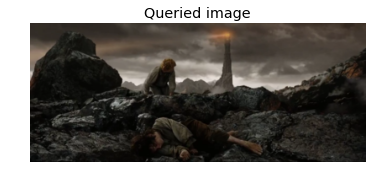

In [262]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Queried image');

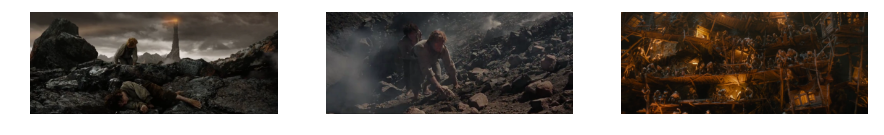

In [263]:
f, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
for j, img in enumerate(result[0:3]):
    axs[j].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axs[j].axis('off')